# Miniproyecto 2

En este Jupyter Notebook pueden implementar los códigos necesarios para resolver el **Miniproyecto 2**.

**Importante:** Recuerden que, como grupo, deben **adjuntar el código** en su entrega. En caso de que desarrollen parte del trabajo en este notebook pero **no lo incluyan en la entrega**, **toda la sección de calificación correspondiente al código será evaluada con cero**.

Tengan en cuenta que Coursera utiliza recursos compartidos entre todos los grupos, por lo tanto, si hay muchos equipos trabajando al mismo tiempo, los procesos pueden demorar más de lo previsto.

Pueden agregar todas las celdas de código que consideren necesarias para resolver el miniproyecto. **No hay un límite en este aspecto.**

In [1]:
# Espacio para desarrollar el código del miniproyecto 2

In [2]:
! pip install kagglehub
! pip install kagglehub[pandas-datasets]

In [3]:
import numpy as np
import random
import os
import tensorflow as tf
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [4]:
import kagglehub
import os
import glob
import pandas as pd

path = kagglehub.dataset_download("yasserh/imdb-movie-ratings-sentiment-analysis")

for root, dirs, files in os.walk(path):
    for name in files:
        print(" -", os.path.join(root, name))

csv_files = glob.glob(f"{path}/**/*.csv", recursive=True)

if not csv_files:
    raise FileNotFoundError("No se encontró ningún archivo .csv en el dataset descargado.")

csv_path = csv_files[0]

data_raw = pd.read_csv(csv_path)

print("\nPrimeras 5 filas del dataset:")
print(data_raw.head())


 - C:\Users\mhgua\.cache\kagglehub\datasets\yasserh\imdb-movie-ratings-sentiment-analysis\versions\1\movie.csv

Primeras 5 filas del dataset:
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1


In [5]:
data = data_raw.copy()
data.shape

(40000, 2)

In [6]:
data.value_counts('label')

label
0    20019
1    19981
Name: count, dtype: int64

## Preprocesado

### Tokenizer

In [7]:
! pip install nltk
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mhgua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhgua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhgua\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
text = data['text'][0]
tokens = word_tokenize(text)
print(tokens)

['I', 'grew', 'up', '(', 'b', '.', '1965', ')', 'watching', 'and', 'loving', 'the', 'Thunderbirds', '.', 'All', 'my', 'mates', 'at', 'school', 'watched', '.', 'We', 'played', '``', 'Thunderbirds', "''", 'before', 'school', ',', 'during', 'lunch', 'and', 'after', 'school', '.', 'We', 'all', 'wanted', 'to', 'be', 'Virgil', 'or', 'Scott', '.', 'No', 'one', 'wanted', 'to', 'be', 'Alan', '.', 'Counting', 'down', 'from', '5', 'became', 'an', 'art', 'form', '.', 'I', 'took', 'my', 'children', 'to', 'see', 'the', 'movie', 'hoping', 'they', 'would', 'get', 'a', 'glimpse', 'of', 'what', 'I', 'loved', 'as', 'a', 'child', '.', 'How', 'bitterly', 'disappointing', '.', 'The', 'only', 'high', 'point', 'was', 'the', 'snappy', 'theme', 'tune', '.', 'Not', 'that', 'it', 'could', 'compare', 'with', 'the', 'original', 'score', 'of', 'the', 'Thunderbirds', '.', 'Thankfully', 'early', 'Saturday', 'mornings', 'one', 'television', 'channel', 'still', 'plays', 'reruns', 'of', 'the', 'series', 'Gerry', 'Anderso

### Stemming: SnowBallStemmer

In [9]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english") 
stemmer.stem(text)

'i grew up (b. 1965) watching and loving the thunderbirds. all my mates at school watched. we played "thunderbirds" before school, during lunch and after school. we all wanted to be virgil or scott. no one wanted to be alan. counting down from 5 became an art form. i took my children to see the movie hoping they would get a glimpse of what i loved as a child. how bitterly disappointing. the only high point was the snappy theme tune. not that it could compare with the original score of the thunderbirds. thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created. jonatha frakes should hand in his directors chair, his version was completely hopeless. a waste of film. utter rubbish. a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp. sapiens was a huge error of judgment.'

### Embeddings: Tf-IDF Vectorizer

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Pipeline completo de preprocesamiento

In [11]:
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


In [12]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

def preprocess_text_lemmatized(text):
    # 1. Limpieza con Regex
    text = re.sub(r'<[^>]+>', '', text)      # HTML tags
    text = re.sub(r'http\S+|www\S+', '', text) # URLs
    text = re.sub(r'\S+@\S+', '', text)      # Emails
    #text = re.sub(r'\d+', '', text)          # Números
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Puntuación y caracteres especiales
    text = text.lower()
    
    tokens = word_tokenize(text)
    
    lemmas = [lemmatizer.lemmatize(token) 
              for token in tokens 
              if token not in stop_words and len(token) > 2]
    
    # 4. Unión
    return ' '.join(lemmas)

# Lambda sobre la columna (usa la nueva función)
preprocessor = FunctionTransformer(lambda X: X.apply(preprocess_text_lemmatized))

# Pipeline (sin cambios en la estructura)
procesador = Pipeline([
    ('preprocessor', preprocessor)])

## Modelo

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Split de datos
X = data['text']
y = data['label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=77)
#### segunda parte

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=77)
#---

print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)

Forma de X_train: (32000,)
Forma de X_val: (4000,)
Forma de X_test: (4000,)


In [15]:
X_train.shape

(32000,)

In [16]:
X_train[0]

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'

In [17]:
y_train.shape

(32000,)

In [18]:
print(f"Primera frase: {X_train[0][0:100]}\n (.....) tiene el label {y_train[0]}")

Primera frase: I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played 
 (.....) tiene el label 0


### Transform

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import re

In [20]:
# Aplicar pipeline
X_train_pre = procesador.fit_transform(X_train) 
X_val_pre = procesador.transform(X_val)
X_test_pre = procesador.transform(X_test)

# Parámetros para tokenización y modelo
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 256
LSTM_UNITS = 32

# Tokenización en textos preprocesados
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_pre)  # Fit solo en train preprocesado

# to_sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_pre)
X_val_seq = tokenizer.texts_to_sequences(X_val_pre)
X_test_seq = tokenizer.texts_to_sequences(X_test_pre)

# Padear
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Verifica formas padded
print("Forma de X_train_padded:", X_train_padded.shape)
print("Forma de X_val_padded:", X_val_padded.shape)
print("Forma de X_test_padded:", X_test_padded.shape)

# Convierte y a arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Forma de X_train_padded: (32000, 500)
Forma de X_val_padded: (4000, 500)
Forma de X_test_padded: (4000, 500)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,GRU
from tensorflow.keras import regularizers


model = Sequential([
    #Embedding
    Embedding(input_dim=MAX_VOCAB_SIZE,
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LENGTH),
    # LSTM bidireccional para capturar contexto anterior y posterior
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False,
                       kernel_regularizer=regularizers.l2(1e-4), #Regularización L2
                       recurrent_regularizer=regularizers.l2(1e-4))),#Regularización L2                   
    # Regularización por Dropout
    Dropout(0.5),
    # Capa densa intermedia para mayor capacidad de representación
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    # Regularización #2 por Dropout
    Dropout(0.4),
    Dense(1, activation='sigmoid')])

# Compilar
model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Resumen
model.summary()

c:\Users\mhgua\anaconda3\envs\data\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 173s 170ms/step - accuracy: 0.7970 - loss: 0.4445 - val_accuracy: 0.8733 - val_loss: 0.3284
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 206s 206ms/step - accuracy: 0.9027 - loss: 0.2792 - val_accuracy: 0.8823 - val_loss: 0.3050
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 197s 197ms/step - accuracy: 0.9223 - loss: 0.2365 - val_accuracy: 0.8842 - val_loss: 0.3115
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 179s 179ms/step - accuracy: 0.9338 - loss: 0.2077 - val_accuracy: 0.8820 - val_loss: 0.3314


In [23]:
# Evaluar
test_loss, test_acc = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8930 - loss: 0.2929
Test Accuracy: 0.8930


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
REPORTE DE CLASIFICACIÓN BINARIA
              precision    recall  f1-score   support

    Negativo      0.913     0.865     0.888      1967
    Positivo      0.876     0.920     0.897      2033

    accuracy                          0.893      4000
   macro avg      0.894     0.893     0.893      4000
weighted avg      0.894     0.893     0.893      4000


MATRIZ DE CONFUSIÓN
[[1701  266]
 [ 162 1871]]


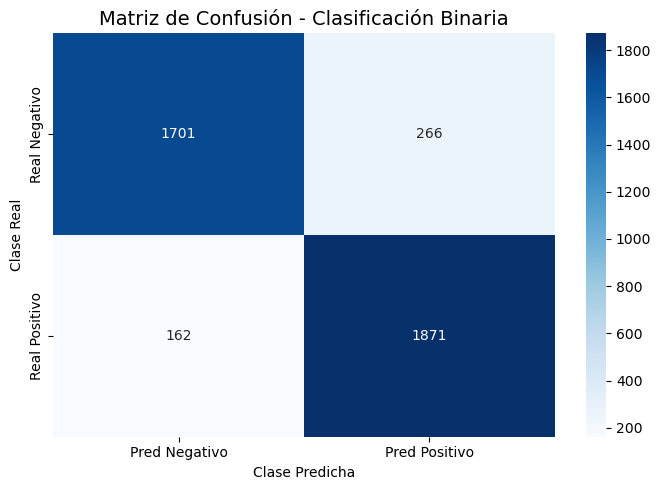


MÉTRICAS GLOBALES
Accuracy  : 89.30%
Precision : 87.55%
Recall    : 92.03%
F1-Score  : 89.74%

ACCURACY POR CLASE
Negativo: 86.48% (1701/1967)
Positivo: 92.03% (1871/2033)

CONFUSIONES MÁS FRECUENTES
Negativo clasificado como Positivo: 266 casos
Positivo clasificado como Negativo: 162 casos


In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================
# 1. PREDICCIONES
# ==============================================================
y_pred_probs = model.predict(X_test_padded)
y_pred_classes = np.where(y_pred_probs > 0.5, 1, 0)  # Umbral binario
y_true_classes = np.array(y_test)  # Asegurar formato numpy

# ==============================================================
# 2. REPORTE DE CLASIFICACIÓN
# ==============================================================
class_names = ['Negativo', 'Positivo']

print("="*60)
print("REPORTE DE CLASIFICACIÓN BINARIA")
print("="*60)
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, digits=3))

# ==============================================================
# 3. MATRIZ DE CONFUSIÓN
# ==============================================================
cm = confusion_matrix(y_true_classes, y_pred_classes)

print("\n" + "="*60)
print("MATRIZ DE CONFUSIÓN")
print("="*60)
print(cm)

# ==============================================================
# 4. VISUALIZACIÓN DE MATRIZ DE CONFUSIÓN
# ==============================================================
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Pred {cls}' for cls in class_names], 
            yticklabels=[f'Real {cls}' for cls in class_names])
plt.title('Matriz de Confusión - Clasificación Binaria', fontsize=14)
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

# ==============================================================
# 5. MÉTRICAS ADICIONALES
# ==============================================================
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n" + "="*60)
print("MÉTRICAS GLOBALES")
print("="*60)
print(f"Accuracy  : {accuracy*100:.2f}%")
print(f"Precision : {precision*100:.2f}%")
print(f"Recall    : {recall*100:.2f}%")
print(f"F1-Score  : {f1*100:.2f}%")

# ==============================================================
# 6. DETALLE POR CLASE
# ==============================================================
print("\n" + "="*60)
print("ACCURACY POR CLASE")
print("="*60)
for i, class_name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_name}: {class_acc*100:.2f}% ({cm[i, i]}/{cm[i].sum()})")

# ==============================================================
# 7. ERRORES (CONFUSIONES)
# ==============================================================
print("\n" + "="*60)
print("CONFUSIONES MÁS FRECUENTES")
print("="*60)
if fp > 0:
    print(f"Negativo clasificado como Positivo: {fp} casos")
if fn > 0:
    print(f"Positivo clasificado como Negativo: {fn} casos")
if fp == 0 and fn == 0:
    print("No hubo confusiones — desempeño perfecto en el conjunto de prueba ✅")


In [25]:
def visualization_history(resultsFit):
    """
    Esta función grafica las curvas de pérdida a lo largo de las épocas de entrenamiento
    para el conjunto de prueba como el de validación.
    Parámetros:
    resultsFit = historial de entrenamiento de un modelo en keras
    Salida:
    Gráfica de la precisión en validación y prueba.
    """
    # Llamado al entrono de la gráfica y fijar tamaño de visualización
    fig, axes = plt.subplots(1, 1, figsize=(13, 4))

    # Graficar la pérdida de la historia en entrenamiento
    axes.plot(range(len(resultsFit.history['loss'])), resultsFit.history['loss'],
           '#5a2ff4', linestyle = "-", marker = ".",
           label='Pérdida entrenamiento', lw = 2)

    # Graficar la presición de la historia en validación
    axes.plot(range(len(resultsFit.history['val_loss'])), resultsFit.history['val_loss'],  '#60d13e',
           label='Pérdida validación', linestyle = '-', marker = '.', lw =2)

    # Títulos de los ejes
    axes.set_xlabel('Época',fontsize=12)
    axes.set_ylabel(r'Pérdida',fontsize=12)
    axes.grid()      # Activar la cuadricula
    axes.legend(fontsize=12,loc = 'upper right')   # Establecer la legenda


    plt.tight_layout() # Ajusta automáticamente el diseño de la figura
    plt.show()

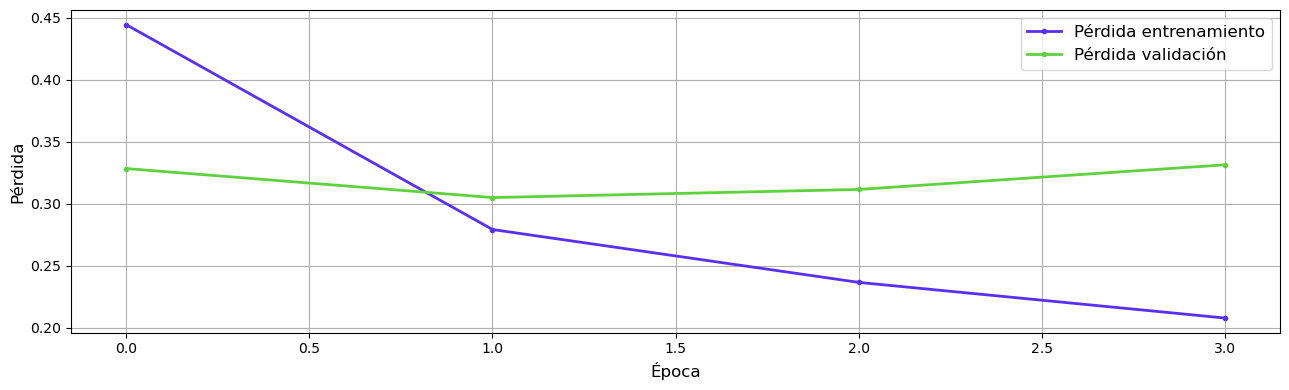

In [26]:
# Llamado a la función de visualización de las métricas de la historia del entrenamiento
# del modelo.
import matplotlib.pyplot as plt
visualization_history(history)

# Análisis cualitativo

In [27]:
! pip install wordcloud

  Using cached wordcloud-1.9.4-cp313-cp313-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.4-cp313-cp313-win_amd64.whl (300 kB)


In [28]:
!apt-get update
!apt-get install -y fonts-dejavu

"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [29]:
import matplotlib.font_manager as fm
fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print(fonts)  # Elige una .ttf de la lista

['C:\\Windows\\Fonts\\LSANSI.TTF', 'C:\\Windows\\Fonts\\constani.ttf', 'C:\\Windows\\Fonts\\GARAIT.TTF', 'C:\\Windows\\Fonts\\msyhbd.ttc', 'C:\\Windows\\Fonts\\l_10646.ttf', 'C:\\Windows\\Fonts\\PERTIBD.TTF', 'C:\\Windows\\Fonts\\DUBAI-MEDIUM.TTF', 'C:\\Windows\\Fonts\\seguiemj.ttf', 'C:\\Windows\\Fonts\\LBRITED.TTF', 'C:\\Windows\\Fonts\\AGENCYR.TTF', 'C:\\Windows\\Fonts\\seguisb.ttf', 'C:\\Windows\\Fonts\\Candaraz.ttf', 'C:\\Windows\\Fonts\\GOUDYSTO.TTF', 'C:\\Windows\\Fonts\\ARIALNI.TTF', 'C:\\Windows\\Fonts\\cambriaz.ttf', 'C:\\Windows\\Fonts\\BRLNSDB.TTF', 'C:\\Windows\\Fonts\\GARABD.TTF', 'C:\\Windows\\Fonts\\segmdl2.ttf', 'C:\\Windows\\Fonts\\TCM_____.TTF', 'C:\\Windows\\Fonts\\bahnschrift.ttf', 'C:\\Windows\\Fonts\\consolaz.ttf', 'C:\\Windows\\Fonts\\IMPRISHA.TTF', 'C:\\Windows\\Fonts\\NIAGSOL.TTF', 'C:\\Users\\mhgua\\AppData\\Local\\Microsoft\\Windows\\Fonts\\fontawesome5-regular-webfont.ttf', 'C:\\Windows\\Fonts\\msyi.ttf', 'C:\\Windows\\Fonts\\VLADIMIR.TTF', 'C:\\Windows\\Fo

In [30]:
# Ejecuta esto en una celda separada
#!pip install --upgrade pillow==9.5.0 wordcloud matplotlib

Análisis de Errores del Modelo

>>> FALSOS NEGATIVOS (Predicho: Negativo (0), Real: Positivo (1))

- Ejemplo: Every Saturday morning at 11 a.m. I watched Superstars. All the biggest events happened on this show at the time. Challenge, which aired Sunday mornings, was decent too, but all the big stuff happened on this show. Wrestlers would do all their interviews with Mean Gene on a platform next to the live crowd or talk on their own to the screen in front of a background that promoted them. The matches were usually squashes but sometimes you would see 2 mid carders square off in the main event. There were also interview shows that usually resulted in violence thus setting up a feud. These segments ranged from Pipers Pit, The Body Shop, The Flower Shop, The Snake Pit, The Brother Love Show, The Funeral Parlor, and The Barber Shop. I don't recall any titles changing hands on this show. That usually happened at pay per views and Saturday Nights Main Event.
(Y 161 más falsos negativos en 

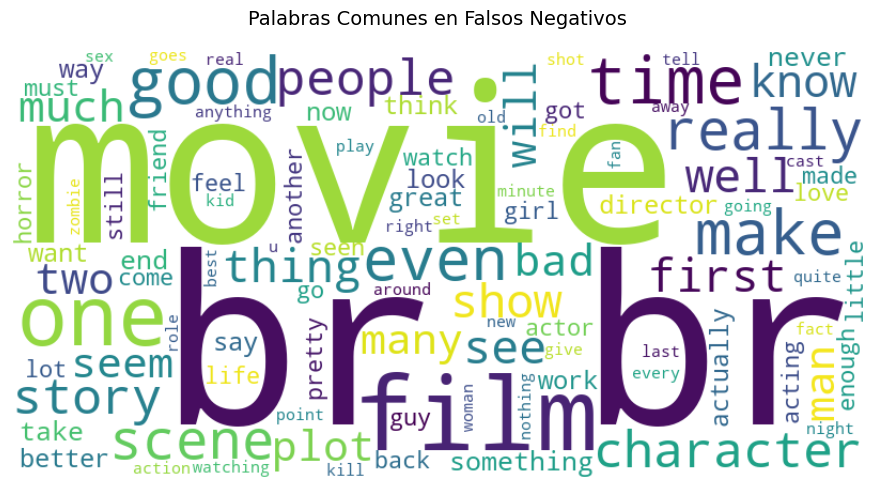

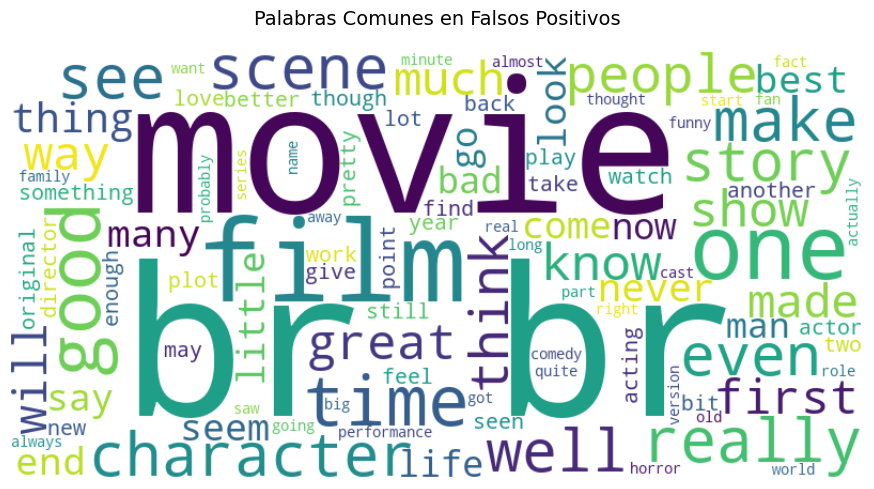

In [31]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Aplanar las etiquetas para asegurar que sean 1D
etiqueta_real_flat = y_test.flatten() if hasattr(y_test, 'flatten') else y_test
prediccion_flat = y_pred_classes.flatten() if hasattr(y_pred_classes, 'flatten') else y_pred_classes

# Crear DataFrame para análisis
df_analysis = pd.DataFrame({
    'texto': X_test,
    'etiqueta_real': etiqueta_real_flat,
    'prediccion': prediccion_flat
})
df_analysis['es_error'] = df_analysis['etiqueta_real'] != df_analysis['prediccion']

print("="*50)
print("Análisis de Errores del Modelo")
print("="*50)

print("\n>>> FALSOS NEGATIVOS (Predicho: Negativo (0), Real: Positivo (1))\n")
false_negatives = df_analysis[(df_analysis['etiqueta_real'] == 1) & (df_analysis['prediccion'] == 0)]
if not false_negatives.empty:
    ejemplo = false_negatives.iloc[0]['texto']
    num_total = len(false_negatives)
    print(f"- Ejemplo: {ejemplo}")
    if num_total > 1:
        print(f"(Y {num_total - 1} más falsos negativos en total)")
else:
    print("No se encontraron Falsos Negativos.")

print("\n>>> FALSOS POSITIVOS (Predicho: Positivo (1), Real: Negativo (0))\n")
false_positives = df_analysis[(df_analysis['etiqueta_real'] == 0) & (df_analysis['prediccion'] == 1)]
if not false_positives.empty:
    ejemplo = false_positives.iloc[0]['texto']
    num_total = len(false_positives)
    print(f"- Ejemplo: {ejemplo}")
    if num_total > 1:
        print(f"(Y {num_total - 1} más falsos positivos en total)")
else:
    print("No se encontraron Falsos Positivos.")

def plot_wordcloud(text_series, title):
    """Genera y muestra una nube de palabras a partir de una serie de textos."""
    if text_series.empty:
        print(f"\nNo hay datos para generar la nube de palabras de '{title}'.")
        return
    
    text = ' '.join(txt for txt in text_series)
    
    if not text.strip():
        print(f"\nNo hay texto suficiente para generar la nube de '{title}'.")
        return
    
    try:
        # SOLUCIÓN: No especificar font_path
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            max_words=100,
            colormap='viridis',
            relative_scaling=0.5,
            min_font_size=10
        ).generate(text)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"\nError al generar nube de palabras para '{title}': {e}")
        print("Intentando método alternativo con frecuencias...")
        
        # Plan B: Usar el método de frecuencias
        try:
            from collections import Counter
            import re
            
            # Tokenizar manualmente
            words = re.findall(r'\b\w+\b', text.lower())
            word_freq = Counter(words)
            
            # Eliminar palabras muy comunes (stopwords básicas)
            stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
                        'of', 'with', 'is', 'was', 'are', 'were', 'be', 'been', 'being',
                        'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
                        'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 
                        'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'br'}
            
            word_freq_filtered = {word: freq for word, freq in word_freq.items() 
                                 if word not in stopwords and len(word) > 2}
            
            # Mostrar top 20 palabras
            print(f"\n📊 Top 20 palabras más frecuentes en {title}:")
            for word, freq in sorted(word_freq_filtered.items(), key=lambda x: x[1], reverse=True)[:20]:
                print(f"   {word}: {freq}")
                
        except Exception as e2:
            print(f"Error en método alternativo: {e2}")

# Generar nubes de palabras
print("\n" + "="*50)
print("Generando Nubes de Palabras...")
print("="*50)

plot_wordcloud(false_negatives['texto'], 'Palabras Comunes en Falsos Negativos')
plot_wordcloud(false_positives['texto'], 'Palabras Comunes en Falsos Positivos')